In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt


## MCMC란,


- 어떤 분포(pdf)로부터 데이터를 sampling 하거나, 분포의 기댓값을 구하기 위해 사용하는 방법이다. high-dimensional pdf일 경우 이 pdf에서 데이터를 샘플링하기가 힘든데, 이를 하기 위한 방법이 MCMC이다. 또는 MCMC는 uncertain parameter model에서 parameter을 추정할 때 쓰기도 한다. 

reference: https://3months.tistory.com/304 [Deep Play]


In [22]:
# P(x) : target distribution
def P(x1,x2,b):
    """
    x1 : mu1
    x2 : mu2
    b : 
    
    a target stationary distribution
    """
    return np.exp(-0.5*(x1**2-2*b*x1*x2+x2**2))


# Q(x) : Proposal distribution
def Q(c, mu1,mu2, sigma):
    # 새로운 normal distribution을 제안한다
    return (c[0]+np.random.normal(mu1,sigma),c[1]+np.random.normal(mu2,sigma))



In [23]:
def metropolis(N, mu1, mu2, sigma, b):
    """
    N :
    mu1 :
    mu2 :
    sigma :
    b :
    """
    current=(10,10)
    sample=[]
    sample.append(current)
    accept_ratio=[]
    
    
    
    for i in range(N):
        candiate=Q(current, mu1,mu2,sigma)
       
        T_prev=P(current[0],current[1],b)
        T_next=P(candiate[0],candiate[1],b)
        a=T_next/T_prev
        
        # acceptance probability : min(1,T_prev/T_next)
        if a>1 or a>np.random.uniform(0,1): 
            #update state
            current=copy.copy(candiate)
            sample.append(current)
            accept_ratio.append(i)
            
    print("Accept ratio : ",float(len(accept_ratio))/N)
    return np.array(sample)

In [24]:
b = 0.5
mu1 = 0
mu2 = 0
sigma = 1

N = 30000
burn_in = 0.2

sample = metropolis(N, mu1, mu2, sigma, b)

Accept ratio :  0.5594666666666667


In [25]:
def main():
    b = 0.5
    mu1 = 0
    mu2 = 0
    sigma = 1

    N = 30000
    burn_in = 0.2

    sample = metropolis(N, mu1, mu2, sigma, b)

    plt.scatter(
        sample[int(len(sample) * burn_in):, 0],
        sample[int(len(sample) * burn_in):, 1],
        alpha=0.3,
        s=5,
        edgecolor='None'
    )
    plt.title('MCMC (Metropolis)')
    plt.show()

    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    plt.hist(sample[int(N * burn_in):,0], bins=30)
    plt.title('x')

    ax = fig.add_subplot(122)
    plt.hist(sample[int(N * burn_in):,1], bins=30)
    plt.title('y')
    plt.show()

    print('x:', np.mean(sample[int(len(sample) * burn_in):,0]), np.var(sample[int(len(sample) * burn_in):,0]))
    # => x: -0.00252259614386 1.26378688755
    print('y:', np.mean(sample[int(len(sample) * burn_in):,1]), np.var(sample[int(len(sample) * burn_in):,1]))
    # => y: -0.0174372516771 1.24832585103

Accept ratio :  0.5566


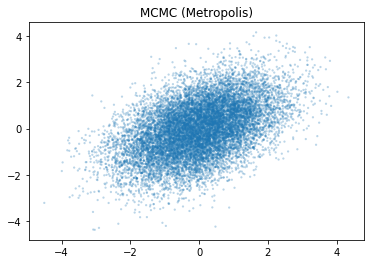

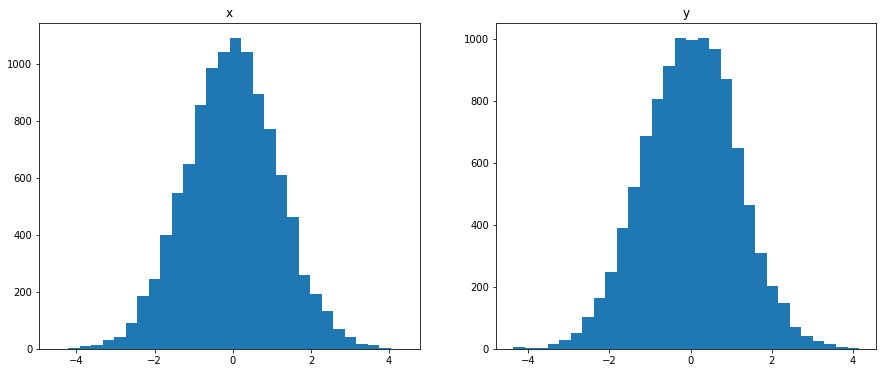

x: -0.008805987469693513 1.3473585871619358
y: -0.010050689270702419 1.3168619887712745


In [26]:
main()

In [42]:
np.random.uniform(0,1) # 0 ~ 1까지의 모든 수가 동일한 확률로 뽑힌다

0.9015595794856536

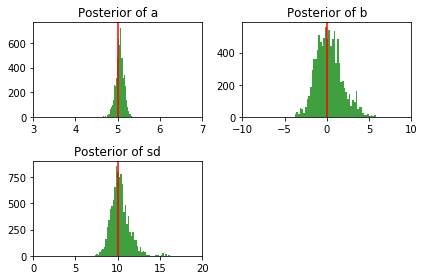

In [43]:
'''
A Simple Metropolis-Hastings MCMC in R by Florian Hartig
(https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/)
Python implementation by zeforro (September 21th, 2017)
Bayesian linear regression using Metropolis-Hastings.
func:	y = a*x + b + sd

		a  : slope
		b  : intercept
		sd : noise
		x  : data
		y  : observation
goal:	p(a,b,sd | x,y) 
		: posterior distribution
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
eps = 1e-6

# initial value
trueA = 5 # slope
trueB = 0 # intercept
trueSD = 10 # noise

# creating sample data
N = 51
x = np.zeros(N)
y = np.zeros(N)
for i in range(N):
	x[i] = i - 15
	y[i] = trueA * x[i] + trueB + np.random.randn() * trueSD
'''
# plot sample data
plt.plot(x,y,'o')
plt.show()
'''

# likelihood (logarithm)
def likelihood(a,b,sd):
	pred = a*x + b # predictions
	single_likelihood = norm.logpdf(y, loc=pred, scale=sd) # loc=mean, scale=var
	return sum(single_likelihood)
'''
# example of likelihood for slope a : [3,7]
slope_A = np.zeros(81)
for i in range(81):
	slope_A[i] = 3 + i*0.05
slopell_A = map(lambda z: likelihood(z,trueB,trueSD), slope_A)
plt.plot(slope_A,slopell_A)
plt.show()
'''

# prior (logarithm)
def prior(a,b,sd):
	# 'uninformative' paramters for a_prior and b_prior
	# (uniform distribution and normal distribution)
	a_prior = uniform.logpdf(a,loc=0,scale=10) # MIN=loc, MAX=loc+scale
	b_prior = norm.logpdf(b,scale=5) # loc=mean(default:0),scale=var
	# 1/sigma is applied for denying standard deviation's informativeness.
	# (check 'Jeffreys Prior' for more detail.)
	# (add epsilon constant to avoid division by zero.)
	sd_prior = 1/(sd+eps) * uniform.logpdf(sd,loc=0,scale=30) # MIN=loc, MAX=loc+scale
	return a_prior + b_prior + sd_prior

# posterior
def posterior(parameter):
	a = parameter[0]
	b = parameter[1]
	sd = parameter[2]
	return likelihood(a,b,sd) + prior(a,b,sd) # logpdf

# Metropolis-Hastings Algorithm
def Metropolis_Hastings(parameter_init, iteration_time):
	result = []
	result.append(parameter_init)
	#count = 0
	for t in range(iteration_time):
		step_var = [0.4, 0.4, 0.4]
		proposal = np.zeros(3)
		for i in range(3):
			proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i]) # norm.rvs : random variable
			# mean=previous parameter, var=step_var
		probability = np.exp(posterior(proposal) - posterior(result[-1])) 
	
		if (uniform.rvs() < probability): # acceptance probability
			result.append(proposal)
			#count += 1
		else:
			result.append(result[-1])
	return result

# main program
parameter_0 = [4,0,10]
iter_t = 20000
result = Metropolis_Hastings(parameter_0, iter_t)
burnIn = 10000
result = result[burnIn:]

# plotting the result
a_result = np.zeros(burnIn)
b_result = np.zeros(burnIn)
sd_result = np.zeros(burnIn)
for i in range(burnIn):
	a_result[i] = result[i][0]
	b_result[i] = result[i][1]
	sd_result[i] = result[i][2]
fig, axarr = plt.subplots(2,2)
axarr[0,0].hist(a_result, 50, facecolor='green', alpha=0.75)
axarr[0,0].axvline(5.0,color='r')
axarr[0,0].set_xlim(3.0,7.0)
axarr[0,0].title.set_text('Posterior of a')
axarr[0,1].hist(b_result, 50, facecolor='green', alpha=0.75)
axarr[0,1].axvline(0.0,color='r')
axarr[0,1].set_xlim(-10.0,10.0)
axarr[0,1].title.set_text('Posterior of b')
axarr[1,0].hist(sd_result, 50, facecolor='green', alpha=0.75)
axarr[1,0].axvline(10.0,color='r')
axarr[1,0].set_xlim(0.0,20.0)
axarr[1,0].title.set_text('Posterior of sd')
fig.delaxes(axarr[1,1])
plt.tight_layout()
plt.show()
